## 게임 매출 관련 전처리 및 분석 진행

## 실험 환경

In [8]:
# !pip install matplotlib
# !pip install seaborn

import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

print("===== 필수 라이브러리 버전 정보 =====")
print(f"Python      : {sys.version.split()[0]}")
print(f"Pandas      : {pd.__version__}")
print(f"Seaborn     : {sns.__version__}")
print(f"Matplotlib  : {matplotlib.__version__}")
print(f"Numpy       : {np.__version__}")
print("===================================")

===== 필수 라이브러리 버전 정보 =====
Python      : 3.10.16
Pandas      : 2.2.3
Seaborn     : 0.13.2
Matplotlib  : 3.10.3
Numpy       : 1.23.5


## 실험 코드

### merged_genre_top5_display.csv: 장르별 게임 매출 5위 게임 데이터
### overall_top10_display.csv: 전체 게임 매출 10위 내 게임 데이터 + 유저 수

In [4]:
# 1. 데이터 로딩
mg_raw_df = pd.read_csv("mobile-games.csv")
pc_raw_df = pd.read_csv("Mobile_games.csv")

# 2. 게임명 정제 함수
def clean_game_name(name):
    if pd.isnull(name): return ""
    return name.strip().lower().split(" / ")[0]

# 3. 유저 수 정제 함수
def parse_player_count(count_str):
    if pd.isnull(count_str):
        return 0

    text = str(count_str)
    match = re.search(r'(\d*\.?\d+)\s*(million)', text, flags=re.IGNORECASE)
    
    if match:
        num_str = match.group(1)
        try:
            num = float(num_str)
            return int(num * 1_000_000)
        except ValueError:
            return 0
    else:
        return 0

# 4. 컬럼명 및 주요 컬럼 정제
mg_raw_df.rename(columns={
    'Game': 'Game_Orig',
    'Genre(s)': 'Genres_Raw'
}, inplace=True)

mg_raw_df['Game_standard'] = mg_raw_df['Game_Orig'].map(clean_game_name)
mg_raw_df['Revenue'] = pd.to_numeric(mg_raw_df['Revenue'], errors='coerce')
mg_raw_df = mg_raw_df.dropna(subset=['Revenue'])

pc_raw_df.rename(columns={
    'Game Title': 'Game_Title',
    'Player count': 'Player_Count_Raw'
}, inplace=True)

pc_raw_df['Game_standard'] = pc_raw_df['Game_Title'].map(clean_game_name)
pc_raw_df['Player_Count'] = pc_raw_df['Player_Count_Raw'].map(parse_player_count)

# 5. 장르 explode 처리
mg_cleaned_df = mg_raw_df.copy()
mg_cleaned_df['Genres_Raw'] = mg_cleaned_df['Genres_Raw'].fillna('')
mg_cleaned_df['Genre'] = mg_cleaned_df['Genres_Raw'].str.lower().str.replace(" ", "", regex=False).str.split(' / ')
mg_cleaned_df = mg_cleaned_df.explode('Genre')

# 6. 데이터 병합
pc_cleaned_df = pc_raw_df[['Game_standard', 'Player_Count']].copy()
all_merged_df = mg_raw_df.merge(pc_cleaned_df, on='Game_standard', how='left')
all_merged_df['Player_Count'] = all_merged_df['Player_Count'].fillna(0).astype(int)

# 7-1. 장르별 매출 상위 5개 게임
genre_top5_df = (
    mg_cleaned_df.sort_values(['Genre', 'Revenue'], ascending=[True, False])
    .groupby('Genre')
    .head(5)
    .reset_index(drop=True)
)
genre_top5_df.to_csv("merged_genre_top5_display.csv", index=False)

# 7-2. 전체 매출 상위 10개 게임
top10_df = (
    all_merged_df.sort_values('Revenue', ascending=False)
    .drop_duplicates('Game_standard')
    .head(10)
)
top10_df.to_csv("overall_top10_display.csv", index=False)


## 시각화 코드 
### 장르별 상위 게임 매출 비교(막대 그래프)

In [5]:
mg_df = pd.read_csv("merged_genre_top5_display.csv")
og_df = pd.read_csv("overall_top10_display.csv")

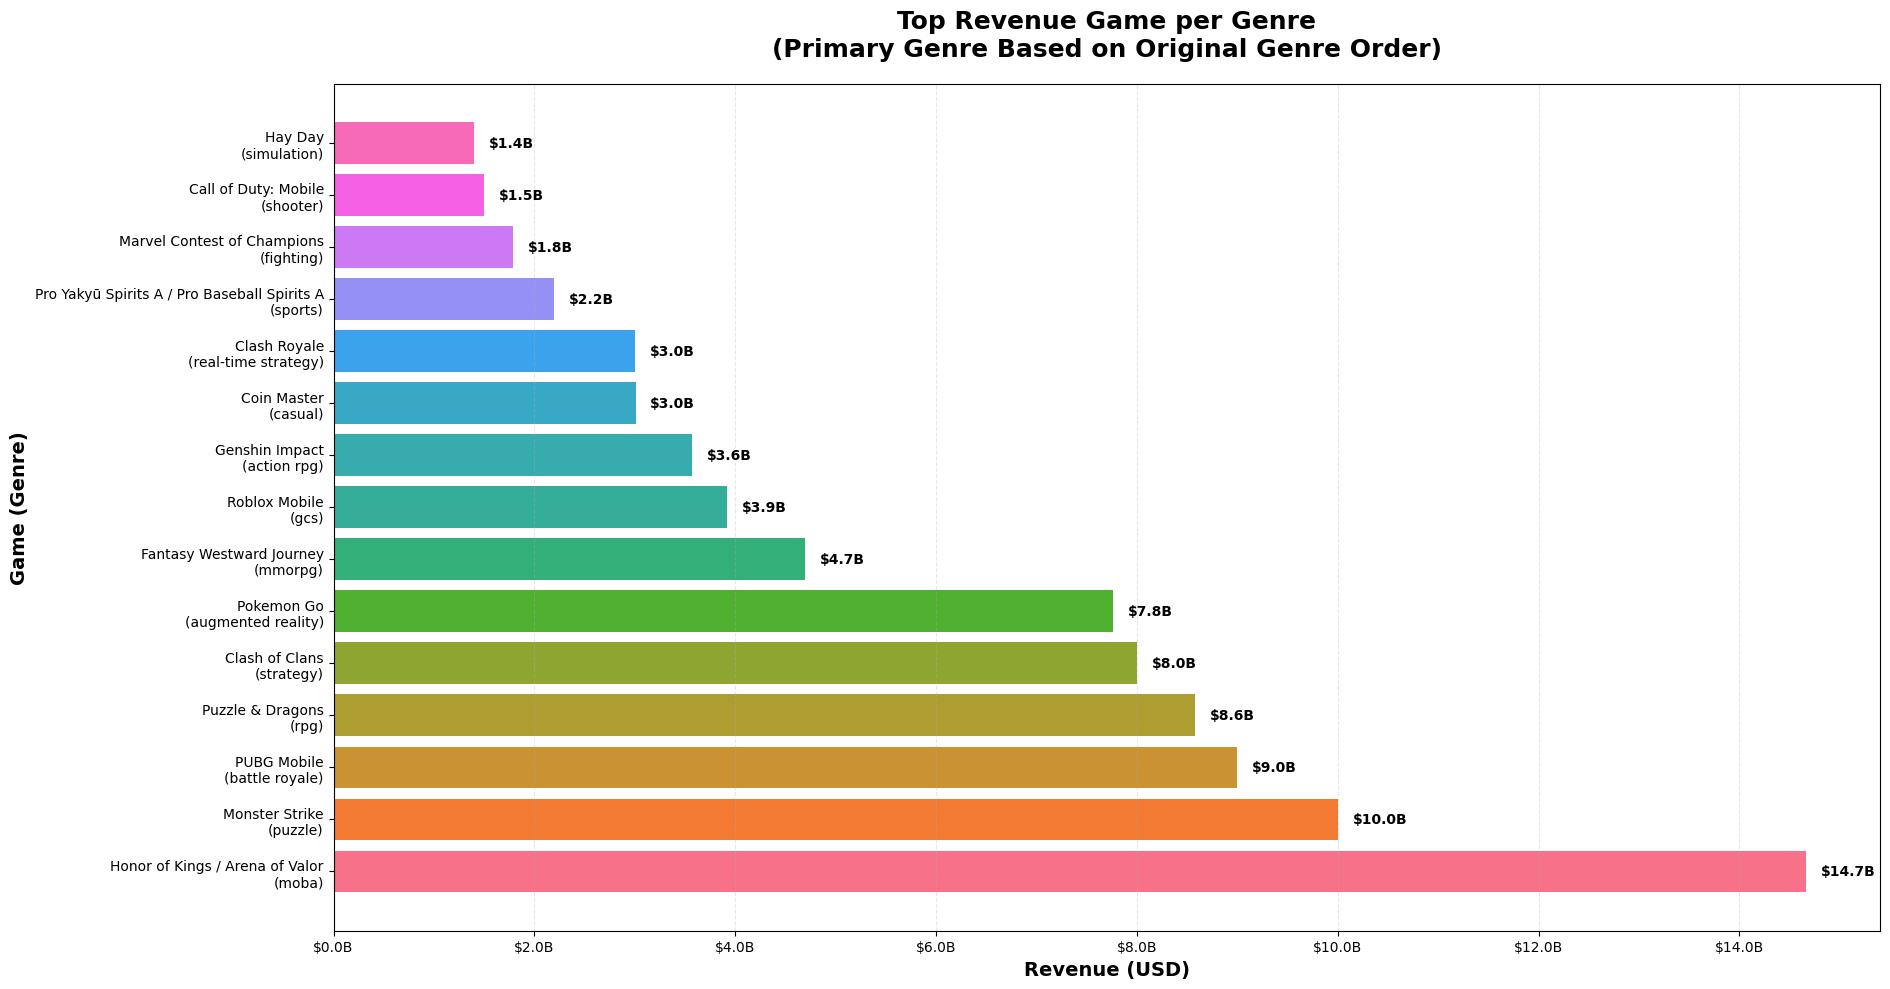

In [9]:
# 1. 장르별 상위 게임 매출 비교 (막대 그래프)

# 원본 장르에서 첫 번째 장르 추출 함수
def get_primary_genre(genres_raw):
    if pd.isnull(genres_raw):
        return 'unknown'
    
    # 괄호 제거 후 첫 번째 장르 추출
    cleaned = re.sub(r'\([^)]*\)', '', str(genres_raw))
    first_genre = cleaned.split(' / ')[0].strip().lower()
    
    return first_genre if first_genre else 'unknown'

# 각 게임의 주 장르(첫 번째 장르) 추출
mg_df['Primary_Genre'] = mg_df['Genres_Raw'].apply(get_primary_genre)

# 각 주 장르별로 매출이 가장 높은 게임 1개씩만 선택
mg_df_top_per_genre = (
    mg_df.sort_values('Revenue', ascending=False)
    .groupby('Primary_Genre')
    .first()
    .reset_index()
)

# 매출 순으로 정렬
mg_df_sorted_for_plot = mg_df_top_per_genre.sort_values(by='Revenue', ascending=False)

# 상위 15개 장르만 선택 (시각화의 가독성을 위해)
top_genres = 15
mg_df_plot = mg_df_sorted_for_plot.head(top_genres)

# 시각화
plt.figure(figsize=(19, 10))

# 색상 팔레트 설정
colors = sns.color_palette("husl", len(mg_df_plot))

# 바 차트 생성
bars = plt.barh(range(len(mg_df_plot)), mg_df_plot['Revenue'], color=colors)

# Y축 레이블 설정 (게임명 + 장르)
y_labels = [f"{row['Game_Orig']}\n({row['Primary_Genre']})" 
           for _, row in mg_df_plot.iterrows()]
plt.yticks(range(len(mg_df_plot)), y_labels)

# 각 바에 매출 값 표시
for i, (_, row) in enumerate(mg_df_plot.iterrows()):
    revenue_billions = row['Revenue'] / 1_000_000_000
    plt.text(row['Revenue'] + max(mg_df_plot['Revenue']) * 0.01, i, 
             f'${revenue_billions:.1f}B', 
             va='center', fontsize=10, fontweight='bold')

# 차트 스타일링
plt.title('Top Revenue Game per Genre\n(Primary Genre Based on Original Genre Order)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Revenue (USD)', fontsize=14, fontweight='bold')
plt.ylabel('Game (Genre)', fontsize=14, fontweight='bold')

# X축 포맷팅 (10억 단위로 표시)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))

# 그리드 추가
plt.grid(axis='x', alpha=0.3, linestyle='--')

# 레이아웃 조정
plt.tight_layout()

# 이미지 저장
plt.savefig('genre_top_games_revenue_bar.png', dpi=300, bbox_inches='tight')
plt.show()

### 전체 매출 상위 10개 게임의 매출 및 유저 수 비교(산점도)

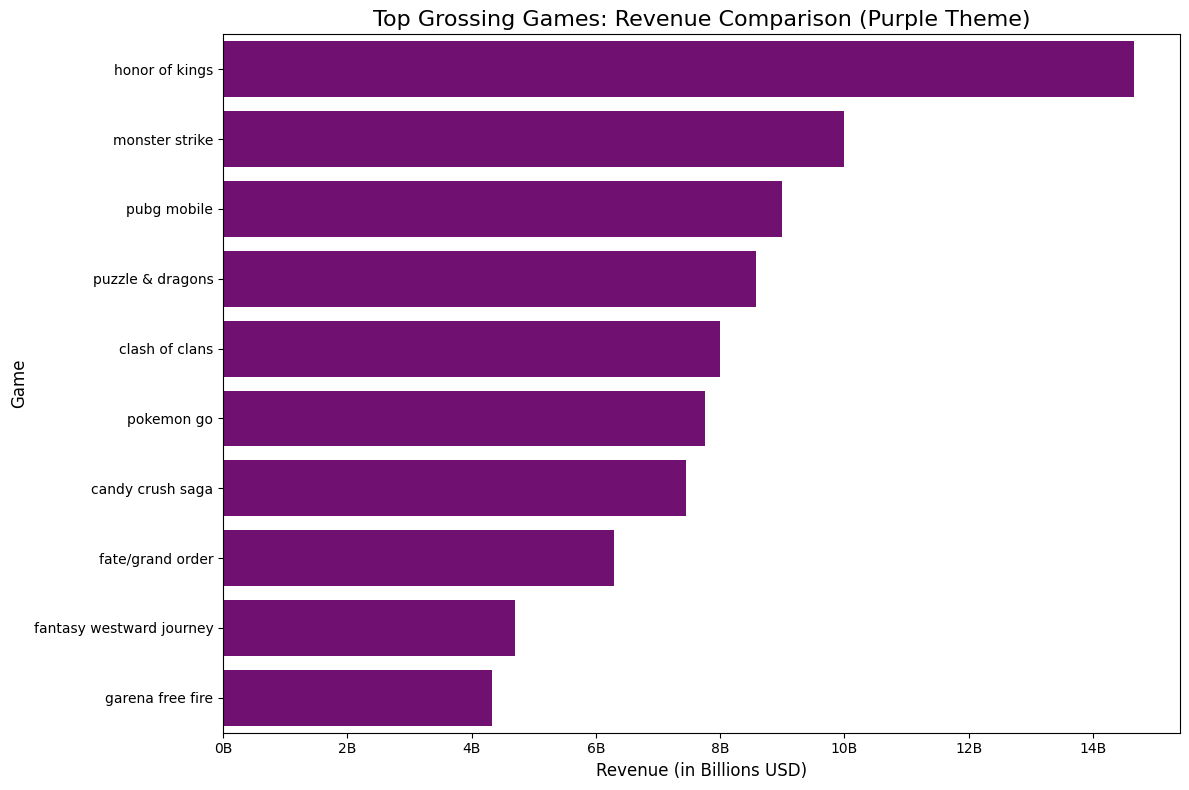

In [10]:
# 전체 매출 상위 게임 매출 비교 (막대 그래프)
# overall_top10_display.csv 사용
# 매출액(Revenue)을 기준으로 내림차순 정렬
plot_df_revenue_top = og_df.sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=plot_df_revenue_top, x='Revenue', y='Game_standard', color='purple')

plt.title('Top Grossing Games: Revenue Comparison (Purple Theme)', fontsize=16) # 제목에 테마 명시
plt.xlabel('Revenue (in Billions USD)', fontsize=12)
plt.ylabel('Game', fontsize=12)

# x축 레이블을 십억 단위로 표시하고 'B' 추가 (예: 14B)
formatter = plt.FuncFormatter(lambda x, pos: f'{x/1e9:.0f}B')
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('overall_top_games_revenue_barplot.png') # 이미지 파일 이름 변경
plt.show()

### 주요 장르별 총 매출액 비중(파이 차트)

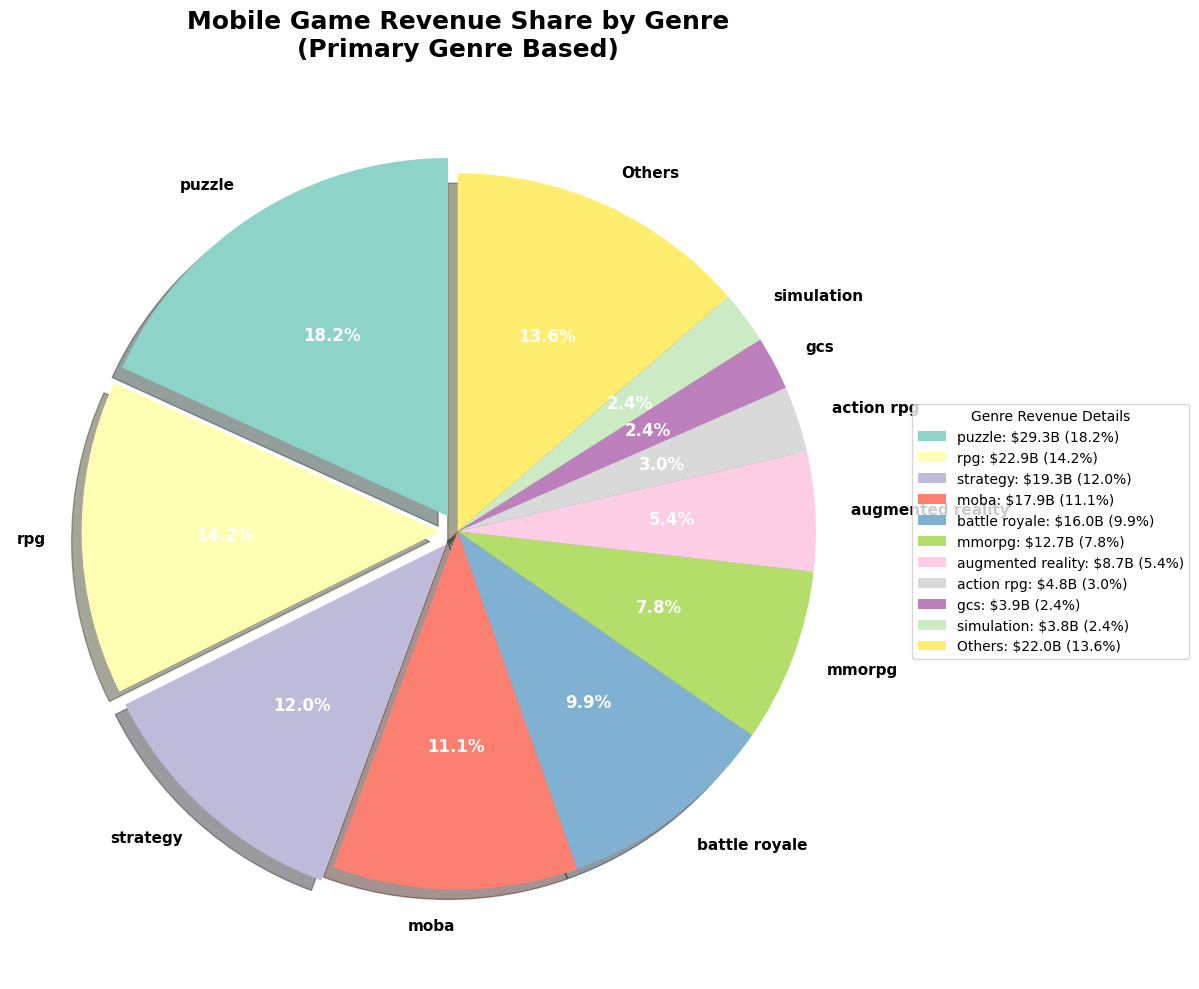

In [11]:
# 주요 장르별 총 매출액 비중 (파이 차트)
# merged_genre_top5_display.csv 사용
# 원본 장르에서 첫 번째 장르 추출 함수
def get_primary_genre(genres_raw):
    if pd.isnull(genres_raw):
        return 'unknown'
    
    # 괄호 제거 후 첫 번째 장르 추출
    cleaned = re.sub(r'\([^)]*\)', '', str(genres_raw))
    first_genre = cleaned.split(' / ')[0].strip().lower()
    
    return first_genre if first_genre else 'unknown'

# 각 게임의 주 장르(첫 번째 장르) 추출
mg_df['Primary_Genre'] = mg_df['Genres_Raw'].apply(get_primary_genre)

# 장르별 총 매출 계산
genre_revenue = mg_df.groupby('Primary_Genre')['Revenue'].sum().sort_values(ascending=False)

# 상위 10개 장르 선택 + 나머지를 'Others'로 묶기
top_n = 10
top_genres = genre_revenue.head(top_n)
others_revenue = genre_revenue.iloc[top_n:].sum()

# 파이 차트용 데이터 준비
if others_revenue > 0:
    pie_data = pd.concat([top_genres, pd.Series({'Others': others_revenue})])
else:
    pie_data = top_genres

# 비중 계산
total_revenue = pie_data.sum()
percentages = (pie_data / total_revenue * 100).round(1)

# 파이 차트 생성
plt.figure(figsize=(12, 10))

# 색상 팔레트 설정
colors = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))

# 파이 차트 생성
wedges, texts, autotexts = plt.pie(pie_data.values, 
                                  labels=pie_data.index,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  colors=colors,
                                  explode=[0.05 if i < 3 else 0 for i in range(len(pie_data))],  # 상위 3개 장르 강조
                                  shadow=True)

# 텍스트 스타일링
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

for text in texts:
    text.set_fontsize(11)
    text.set_weight('bold')

plt.title('Mobile Game Revenue Share by Genre\n(Primary Genre Based)', 
          fontsize=18, fontweight='bold', pad=20)

# 범례 추가
plt.legend(wedges, [f'{genre}: ${revenue/1e9:.1f}B ({percentage:.1f}%)' 
                    for genre, revenue, percentage in zip(pie_data.index, pie_data.values, percentages)],
          title="Genre Revenue Details",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

plt.tight_layout()
plt.savefig('genre_revenue_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()